<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font>

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to your assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook.__

<b>Enter you student details below</b>

- <b>Student Name:</b> Alexander Li
- <b>Student ID:</b> 30630711

<div class="alert alert-block alert-danger">

## Table of Contents

* [Libraries](#Libraries)
    
* [Task 5.1: Create dataloaders and visualize the dataset](#t5_1)
    
* [Task 5.2: Load and Apply Transfer Learning with Pre-trained ViT Base Model](#t5_2)
    
* [Task 5.3: Train and Test the model](#t5_3)
    
* [Task 5.4: Visualise predicted landmarks for some of the images](#t5_4)
    
* [Task 5.5: Discussion Questions](#t5_5)

<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [2]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True

    PATH_DATASETS = '/content/gdrive/MyDrive/ECE4179_assignment/' # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Using Google Colab with file path /content/gdrive/MyDrive/ECE4179_assignment/


In [3]:
# If you run on google colab uncomment bellow comment
!pip install torchmetrics pytorch-lightning torchvision -qq
!pip install imutils
!pip install pytorch-lightning
!pip install lightning

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data.dataset import Dataset
from torchmetrics import MeanSquaredError

import lightning as pl ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


BATCH_SIZE = 64 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 ## Set to your device

INFO: Seed set to 4179
INFO:lightning.fabric.utilities.seed:Seed set to 4179


<div class="alert alert-block alert-info">

# Face Landmarks Detection with Transfer Learning
    
## What you should do in this task!

In this task you will be applying transfer learning on a (Vision Transformer) ViT model for the Face Landmark Detection task using Pytorch and PyTorch Lightning. You can read the original paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) to learn more about the ViT model.

You have to use Pytorch inbuilt models to load the ViT model and its pre-trained parameters, then use the Pytorch Lightning module class to modify the ViT model architecture in order to detect landmarks of human faces. As always, we will train our model using stochastic gradient descent (SGD).

#### In this task, you will work on the following points:
 1. Prepare the dataset and create dataloaders with suggested transformations.
 2. Visualise a training sample with ground truth landmark points.
 3. Modify the ViT model (Idea of ViT is images should be fed to a transformer and the features from the transformer being used by an MLP).
 4. Perform training and evaluation of the model.
 5. Visualise your experimental results.
    
<img src="figures/face_landmarks.png" width="700" align="center">

<div class="alert alert-block alert-info">
    
### Task 5.1: Create dataloaders and visualize the dataset <a class="anchor" id="t5_1"></a>
    
In this section you have to create dataloaders for the face landmarks dataset. To do so, begin by crafting a Dataset class called **FLD_Data** to read data from **face_landmark.npz**. Then, visualise a few samples of the data along with the landmarks.

The FLD data can be loaded in completely since it is relatively small.

Have a look at how the data is loaded in to understand how to access the data for the modelling process. You do NOT have to edit the FLD_Data class!

In [4]:
class FLD_Data(Dataset):
    def __init__(self, trn_tst = 0, transform=None):
        # Load numpy data
        data = np.load(PATH_DATASETS + 'data/face_landmark.npz')
        print(data)
        if trn_tst == 0:
            # Create dataset for trainloader
            self.images = data["train_images"]
            self.images = np.delete(self.images, [178,435], axis=0) # remove the corrupted images
            self.landmarks = data["train_landmarks"]
            self.landmarks = np.delete(self.landmarks, [178, 435], axis=0) # remove the corrupted landmarks
        else:
            # Create dataset for testloader
            self.images = data["test_images"]
            self.landmarks = data["test_landmarks"]

        self.transform = transform   ## Save the transforms as your class' attributes

    # Define len function
    def __len__(self):
        return self.images.shape[0]

    # Define getitem function
    def __getitem__(self, idx):

        images = self.images[idx]
        landmarks = self.landmarks[idx]

        if self.transform is not None:  ## If there is a transform, apply it here to your sample
            images = self.transform(images)

        return images, landmarks ## Useful for using MSE loss later on

In [5]:
# Define a series of image transformations to be applied to data
data_transforms = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])     # Normalize pixel values to have a mean and standard deviation of 0.5
])

In [6]:
## Set your train and test datasets
train_dataset = FLD_Data(trn_tst=0, transform=data_transforms)
test_dataset = FLD_Data(trn_tst=1, transform=data_transforms)

Using the 'random_split' function, create a validation dataset by using 10% of training data.

In [7]:
# split the dataset into validation and test sets
# use 10% data as validation data from training data
len_valid_set = int(0.1*len(train_dataset)) ## 10% of the data data
len_train_set = len(train_dataset) - len_valid_set  ## 90% of the remaining train data

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset , [len_train_set, len_valid_set])  ## Split train data

# shuffle relevant datasets and use the torch dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# You can print the length of the train, validation, and test set to ensure they are correct
print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len(test_dataset)))

The length of Train set is 694
The length of Valid set is 77
The length of Test set is 221


In [8]:
# Write visualize_dataloader function to visualize 3 images from a given data loader

# Define a function to visualize images from a data loader
# Input parameters: dataloader
def visualize_dataloader(dataloader):

    # Create a figure with subplots to display images
    fig, axes = plt.subplots(figsize=(16, 8), ncols=3)

    # Get a batch of images and labels from the data loader
    images, landmarks = next(iter(dataloader))

    # Loop through the first 3 images in the batch
    for i in range(3):
        ax = axes[i]
        image = images[i].numpy().transpose(1, 2, 0)
        lms = landmarks[i].numpy()
        #print(label)
        ax.imshow(image)
        ax.scatter(lms[:,0], lms[:,1], marker='o', c='c')
        ax.axis('off')
        ax.set_aspect('equal')

    # Show the plot
    plt.show()

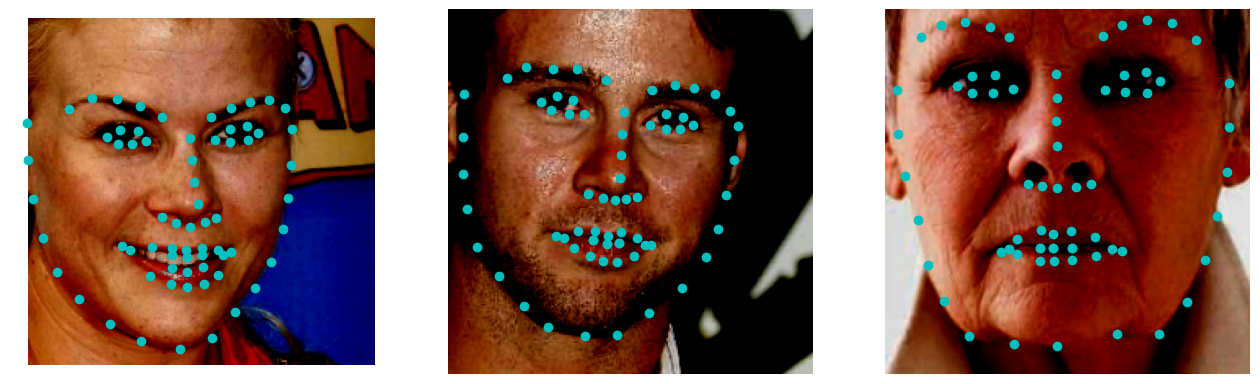

In [9]:
# Visualise 3 images as well as their corresponding facial landmarks from the test_loader

visualize_dataloader(test_loader)

<div class="alert alert-block alert-info">
    
### Task 5.2: Load and Apply Transfer Learning with Pre-trained ViT Base Model <a class="anchor" id="t5_2"></a>

Transfer learning can be employed when the goal is to use pre-trained models (ie. [ViT](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16)) for a new task. The new task can be classification or numerical estimation, but the important thing about transfer learning is that you need to ensure the dataset used for the pre-training is similar in its distribution to the new task. For example, if you pre-trained model was only trained on classifcation of coloured images, it will not perform well for black and white images!

In this task you need to:
- Load in a **vit_b_16** model **WITH** pretrained weights and print model structure of ViT
- Freeze all the parameters of the **vit_b_16** model (see PDF)
- Apply __linear probing__ by replacing the current FC layer (i.e., the **MLP Head**) in the **vit_b_16** model with a new FC layer (by default, this new FC layer will have non-frozen parameters)
    
    
<img src="figures/vit_model.png" width="700" align="center">

_Note: You will learn more about transformers the later weeks of the course. For now, we will just use ViT as a pre-trained model_

In [10]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Load the model using torchvision and print the model structure
model = vit_b_16()
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [23]:
class FaceLandmarkDetection(pl.LightningModule):
    def __init__(self, learning_rate=0.0001, num_classes=136):
        super().__init__()
        self.learning_rate = learning_rate
        self.loss_fun = nn.MSELoss()  ## Define your loss! What should it be?

        ## Load the pre-trained network as follows
        ## vit_b_16 from models
        ## Use the importedweights of:   ViT_B_16_Weights.IMAGENET1K_V1
        ## See pytorch documentation on how to load models with a pre-trained weight
        self.vit = vit_b_16(weights = ViT_B_16_Weights.IMAGENET1K_V1) ## Load the pre-trained network as follows

        ## Freeze vit_b_16 weights (see PDF's hints)
        ## You can set the param.requires_grad = False
        ## That way those parameters will not get updated
        self.vit.requires_grad = False

        ## Remake the vit_b_16 FC layer. You can use the in_features from the original model
        self.vit.heads.head = nn.Linear(in_features=768, out_features=1000, bias=True)
        self.fc = nn.Linear(in_features=1000, out_features=136, bias=True)
        self.activation = nn.ReLU()

        ## Which error do we use? Remember, we are dealing with minimising coordinate errors in the landmarks
        self.val_error = MeanSquaredError()
        self.train_error = MeanSquaredError()
        self.test_error = MeanSquaredError()

    def forward(self, x):
        #Pass input through the model
        x_out = self.vit(x)
        x_out = self.activation(x_out)
        x_out = self.fc(x_out)
        return x_out

    def training_step(self, batch, batch_idx):
        images, landmarks = batch

        landmarks = landmarks.reshape(-1, 136)
        preds = self(images)  ## Ensure you reshape your landmarks data to compare against the preds
        loss = self.loss_fun(preds.double(), landmarks.double())
        error = self.train_error(preds.double(), landmarks.double())

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_error", error, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, landmarks = batch

        landmarks = landmarks.reshape(-1, 136)
        preds = self(images)  ## Ensure you reshape your landmarks data to compare against the preds
        loss = self.loss_fun(preds.double(), landmarks.double())
        error = self.val_error(preds.double(), landmarks.double())

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_error", error, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        images, landmarks = batch

        landmarks = landmarks.reshape(-1, 136)
        preds = self(images)  ## Ensure you reshape your landmarks data to compare against the preds
        loss = self.loss_fun(preds.double(), landmarks.double())
        error = self.test_error(preds.double(), landmarks.double())

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_error", error, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        images, landmarks = batch
        preds = self(images)

        preds = preds.reshape(-1, 68, 2)
        return preds, landmarks, images   ## Return 3 values here: predicted landmarks, original landmarks and the original image

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

<div class="alert alert-block alert-info">
    
### Task 5.3: Train and Test the model <a class="anchor" id="t5_3"></a>

In [24]:
## Initialise your face landmark model
## Train until the end of max_epochs or if the early stopping condition has occured
## Note that if you implement it similarly to how we have done it (same hyper parameters etc.)
## Then your epoch should stop around ~110 (+/- 25 epochs)

FaceLandmarkDetection_model = FaceLandmarkDetection()

# Define checkpoint callback function to save best model
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="/content/gdrive/MyDrive/ECE4179_assignment/checkpoints_section_5/",
        save_top_k=1,        # save the best model
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=1, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)
# Create Early stopping callback
early_stopping = EarlyStopping('val_loss', patience = 10, mode = 'min')

# Train and test the model
trainer = pl.Trainer(
    accelerator="auto",
    devices=1, # if torch.cuda.is_available() else None,
    max_epochs=100,
    callbacks=[progress_bar_task, checkpoint_callback,  early_stopping],
    logger=CSVLogger(save_dir="/content/gdrive/MyDrive/ECE4179_assignment/logs_task_5/"),
)
trainer.fit(FaceLandmarkDetection_model)

#checkpoint_task5 = torch.load('/content/gdrive/MyDrive/ECE4179_assignment/checkpoints_section_5/epoch=15-step=176.ckpt')
#FaceLandmarkDetection_model.load_state_dict(checkpoint_task5['state_dict'])
trainer.test(FaceLandmarkDetection_model)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 0:00:02 • 0:00:00 1.49it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_error         │    136.13162231445312     │
│         test_loss         │    136.13163279031966     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 136.13163279031966, 'test_error': 136.13162231445312}]

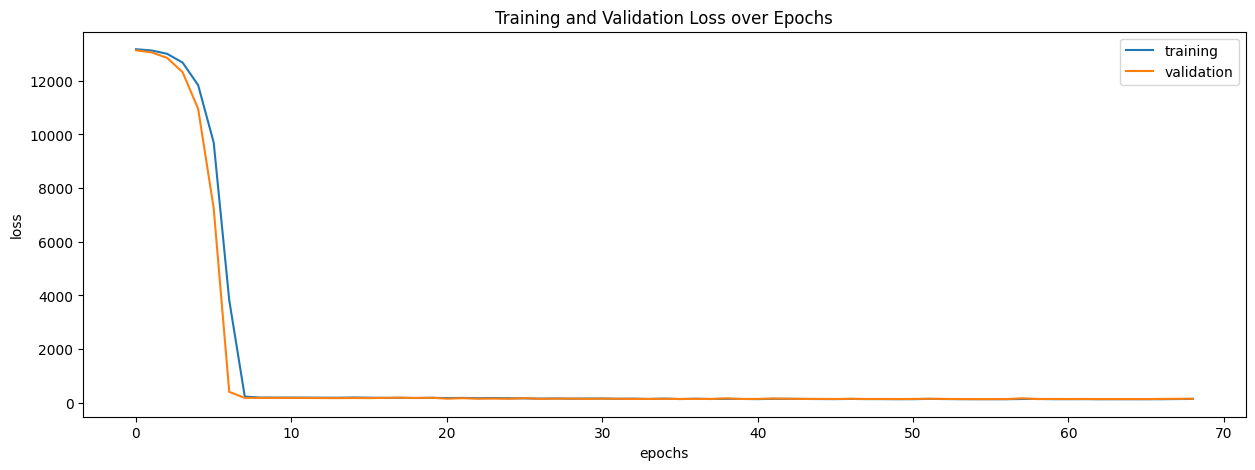

In [25]:
## Plot your train and validation losses!

# read logs , feel free to use your own code for reading logs
#metrics_task = pd.read_csv("/content/gdrive/MyDrive/ECE4179_assignment/logs_task_5/lightning_logs/version_0/metrics.csv")
metrics_task = pd.read_csv(trainer.logger.log_dir + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

# Plot using matplotlib
# You can use your own way of logging if you do not want to use tensorboard.

# Create a figure with all the appropriate labels/titles etc.
train_loss = metrics_task["train_loss"]
val_loss = metrics_task["val_loss"]
plt.figure(0, figsize=(15,5))
plt.plot(train_loss[:-1], label="training")
plt.plot(val_loss[:-1], label="validation")
#plt.xticks(ticks=range(len(val_loss)))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()


<div class="alert alert-block alert-info">
    
### Task 5.4: Visualise predicted landmarks for three of the images <a class="anchor" id="t5_4"></a>
    
Utilise the trainer predict method to output the predicted landmarks. Then overlay this with the original landmarks and the original image.

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


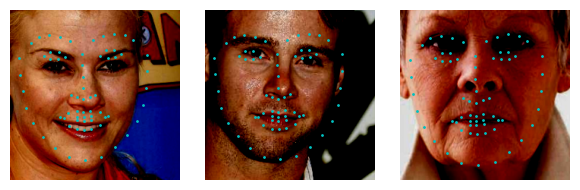

In [26]:
# Get test_loader images with original landmarks and predicted landmarks from model trained using SGD
outputs = trainer.predict(FaceLandmarkDetection_model, test_loader)
preds, landmarks, images = outputs[0]

# Create a subplot with 1 row and 3 columns to display images
num_cols = 3
num_rows = 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2, 2*num_rows))

# Iterate through the first 3 samples for visualization
for i in range(3):
    ax = axes[i]
    image = images[i].numpy().transpose(1, 2, 0)
    lms = preds[i].numpy()
    #print(label)
    ax.imshow(image)
    ax.scatter(lms[:,0], lms[:,1], marker='o', c='c', s=1)
    ax.axis('off')
    ax.set_aspect('equal')


# Show the plotted images
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
    
### Task 5.5: Discussion Questions <a class="anchor" id="t5_5"></a>

### Questions
1. What are two things to keep in mind when choosing your pre-trained model? Why are these important?

2. What are the differences between CNN architectures and Transformer models, such as ViT?

3. What was your thought process in finetuning your model to achieve the required test loss?
    
### Answers
    
1. I should choose a pre-trained model that has the appropriate architecture for the task; this is important because architectures have capabilities and limitations fundamental to those architectures. I should also choose a model that is easy to execute in a forward pass; this is important when computation resource is limited.
    
2. CNN architectures directly extract features in the image with kernels, keeping the spatial information. Transformer models have to work with image patches that are sequentially fed into the model. They don't seem to be as well built for this task of landmark detection, since they're usually used for sequential text problems; the abstraction they can generate is not as useful for precise coordinate placement.

3. Firstly, I knew i wanted at least 2 fc layers, because their function fitting capabilities grow exponentially with the number of layers. I then kept getting nan losses which terminated the training process, so I knew that my model was diverging during training; which led me to reduce the learning rate. Then, I saw that the required test loss was already reached, but the output landmarks were not that good. I increased the number of neurons in the middle layer, hoping to capture the problem better. This required me to reduce the learning rate again as it once again outputted nan losses. This finally brought me to a loss of 136.


<div class="alert alert-block alert-danger">
    
## Final remarks

Well done on making it all the way to the end. We hope you have enjoyed applying deep learning concepts to further your understanding and to new applications !